
#Paquetes


In [1]:
# prompt: mount drive and become a path as the working drectory and add to path system
import pandas as pd
from google.colab import drive
import sys
import os
import time
drive.mount('/content/drive')

path="/content/drive/My Drive/cod/RL_DS_dynamic"
os.chdir(path)
sys.path.append(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet stable-baselines3

In [3]:

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import ProgressBarCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from RL_DS.envs.retailer_gym import RetailerOrdersEnv, RetailerOrdersEnv2
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from RL_DS.utils.norm2 import MinMaxWrapper2
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import time
import numpy as np

# Max scaler SAC

In [4]:
##infor for logs and save models
log_dir = "./logs/pop_log"
monitor_path=log_dir+"/monitor.csv"
bm_name="best_pop" ## best model name to save
bm_path = "logs" ##best model_pathc
bm= f"{bm_path}/{bm_name}"
actions_file=f"{bm_path}/actions.csv"


In [97]:
# Wrap your environment if needed (e.g., normalization)


env = RetailerOrdersEnv2(time_horizon=47, track_data=True)
# Optionally: env = DummyVecEnv([lambda: env])
env_sc= MinMaxWrapper2(env )


env_sc = Monitor(env_sc, filename=monitor_path, override_existing=True)
env_sc = DummyVecEnv([lambda: env_sc])  #

In [98]:

class PerEpisodeEvalCallback(BaseCallback):
    def __init__(self, save_path: str):
        super().__init__()

        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        # Check if the episode ended (SB3 sets 'done' flags in 'infos')

        if "episode" in self.locals["infos"][0]:  # Episode terminated
            if self.model.ep_info_buffer:
                ep_reward,*_ = evaluate_policy(self.model, self.model.get_env(), n_eval_episodes=1, deterministic=True)

                if ep_reward > self.best_mean_reward:
                    #print(f"eva_reward {ep_reward}")
                    #print(f"log_reward {model.ep_info_buffer[-1]['r']}")

                    self.best_mean_reward = ep_reward  # Assign ep_reward, not mean_reward
                    self.model.save(bm)
        return True

In [101]:

eval_callback = PerEpisodeEvalCallback(bm_path)

model = PPO(
    policy="MlpPolicy",
    verbose=True,
    env=env_sc,
    learning_rate=1e-3,
    n_steps=47,
    batch_size=47,                # Smaller batches
    n_epochs=15,
    gamma=1,
    gae_lambda = 1,
    ent_coef=0.05,##00.2 no mejora
    policy_kwargs={"net_arch": [64, 64]},# Small network for faster training
    #seed=0,
    vf_coef=0.8,
    clip_range=50,
    clip_range_vf=None,
    normalize_advantage = True,
    use_sde = True

)




t1=time.time()
model.learn(total_timesteps=9400, progress_bar=True, callback=eval_callback,log_interval=10)
t2=time.time()
print("Training time (minutes):", (t2 - t1) / 60)




Output()

Using cpu device
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 47           |
|    ep_rew_mean          | 14           |
| time/                   |              |
|    fps                  | 383          |
|    iterations           | 10           |
|    time_elapsed         | 1            |
|    total_timesteps      | 470          |
| train/                  |              |
|    approx_kl            | 0.0077066766 |
|    clip_fraction        | 0            |
|    clip_range           | 50           |
|    entropy_loss         | -2.76        |
|    explained_variance   | 0.721        |
|    learning_rate        | 0.001        |
|    loss                 | 2.57         |
|    n_updates            | 135          |
|    policy_gradient_loss | -0.0201      |
|    std                  | 0.999        |
|    value_loss           | 4.02         |
------------------------------------------
-------------------------------------

Training time (minutes): 0.4249157667160034


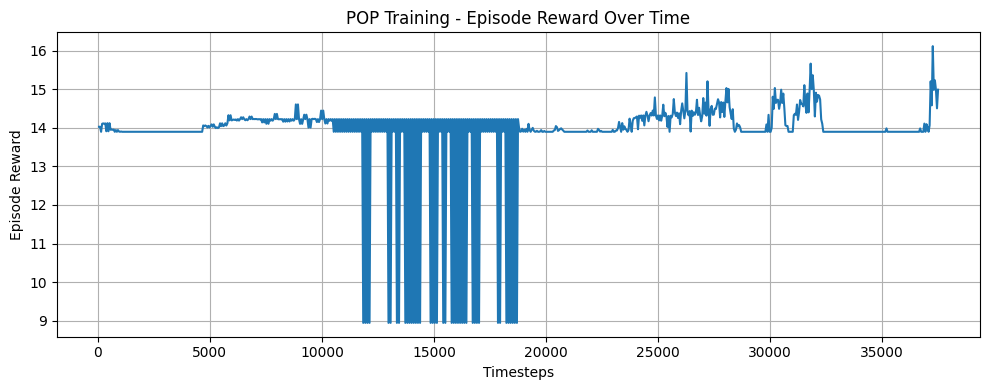

In [102]:

x, y = ts2xy(load_results(log_dir), 'timesteps')

plt.figure(figsize=(10, 4))
plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("POP Training - Episode Reward Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:

test_env= RetailerOrdersEnv2(time_horizon=47, track_data=True)
test_env_sc=  MinMaxWrapper2(test_env )

obs, *_ = test_env_sc.reset()


for step in range(47):
    action, _states = model.predict(obs, deterministic=True)  # Use deterministic actions
    obs, reward, done, truncated, info = test_env_sc.step(action)
    if done:
        break
import pandas as pd
#pd.DataFrame(test_env_sc.env.history)


In [31]:
actions=pd.DataFrame(test_env_sc.env.history)['action']
actions.to_csv(actions_file, index=False)
reward=pd.DataFrame(test_env_sc.env.history).loc[35,'cumulative_cost']
print(f'reward: ',reward)
#122558.46875

reward:  98330.140625


In [32]:
mean_reward, std_reward = evaluate_policy(model,test_env_sc, n_eval_episodes=1, deterministic=True)  # Pass 'model' as a keyword argument
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



Mean reward: 14.36 +/- 0.00


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [33]:
best_model = PPO.load(bm)
best_model.set_env(test_env_sc)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [34]:
mean_reward, std_reward = evaluate_policy(best_model,test_env_sc, n_eval_episodes=1, deterministic=True)  # Pass 'model' as a keyword argument
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")



Mean reward: 14.70 +/- 0.00


In [37]:

test_env= RetailerOrdersEnv2(time_horizon=47, track_data=True)
test_env_sc=  MinMaxWrapper2(test_env )

obs, _ = test_env_sc.reset()

for step in range(47):
    action, _states = best_model.predict(obs, deterministic=True)  # Use deterministic actions
    obs, reward, done, truncated, info = test_env_sc.step(action)
    if done:
        break
import pandas as pd
pd.DataFrame(test_env_sc.env.history)

AttributeError: wrapper MinMaxWrapper2 has no attribute '_elapsed_steps'

In [15]:
actions=pd.DataFrame(test_env_sc.env.history)['action']
actions.to_csv(actions_file, index=False)
reward=pd.DataFrame(test_env_sc.env.history).loc[35,'cumulative_cost']
print(f'reward: ',reward)

reward:  86326.6953125
